Model Creation Template

0. Import Libraries and Get redshift credentials

In [42]:
import pandas as pd
import numpy as np
from catnip.fla_redshift import FLA_Redshift
from sqlalchemy import null
from datetime import datetime

from prefect.blocks.system import Secret
from typing import Dict
from concurrent.futures import ThreadPoolExecutor

import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

1: Missing Data Evaluation

1.1 Import Data

In [3]:
# get 24-25 Premier data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2425
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2425.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Premier')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT DISTINCT
        a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-242024-25' THEN 4
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-242024-25' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2023-242024-25' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2024-25%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2024-25'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2024-25'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        COUNT(*) AS num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND season = '2024-25'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg AS (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal
                     WHEN 'Premium' THEN 1
                     WHEN 'Lower' THEN 2
                     WHEN 'Club' THEN 3
                     ELSE 4
                 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2526.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2526
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2526.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2526.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints, 0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg 
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure 
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info 
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend 
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg 
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    renewal_survey 
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
"""

df_premier_2425 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [4]:
# get 24-25 Full data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2425
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2425.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Full')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT DISTINCT
        a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-242024-25' THEN 4
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-242024-25' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2023-242024-25' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2024-25%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        AND section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2024-25'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2024-25'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        COUNT(*) AS num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        AND season = '2024-25'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg AS (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal
                     WHEN 'Premium' THEN 1
                     WHEN 'Lower' THEN 2
                     WHEN 'Club' THEN 3
                     ELSE 4
                 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2526.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2526
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2526.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2526.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints, 0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg 
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure 
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info 
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend 
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg 
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    renewal_survey 
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
    and zip.email not ilike '%floridapanthers%'
    and zip.email not ilike '%amerantbank%'
"""

df_full_2425 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [8]:
# get 23-24 Premier data

Q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2324
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2324.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Premier')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT
        DISTINCT a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2023'
        AND act.completed_on_coalesce < '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-24' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-24' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2023-24%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2023-24'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2023-24'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        count(*) as num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND season = '2023-24'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg as (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal WHEN 'Premium' THEN 1 WHEN 'Lower' THEN 2 WHEN 'Club' THEN 3 ELSE 4 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
did_renew AS (
    SELECT
        subs_2324.purch_client_crm_id,
        CASE
            WHEN subs_2425.purch_client_crm_id IS NULL THEN 0
            ELSE 1
        END AS did_renew
    FROM
        custom.cth_v_ticket_subscription_2324 subs_2324
    LEFT JOIN
        custom.cth_v_ticket_subscription_2425 subs_2425 ON subs_2324.purch_client_crm_id = subs_2425.purch_client_crm_id
    GROUP BY
        subs_2425.purch_client_crm_id,
        subs_2324.purch_client_crm_id
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2425.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2425
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2425.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2425.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints,0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    did_renew.did_renew,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    did_renew
        ON zip.purch_client_crm_id = did_renew.purch_client_crm_id
LEFT JOIN
    renewal_survey
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
"""

df_premier_2324 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [6]:
# get 23-24 Full data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2324
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2324.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Full')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT DISTINCT
        a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2023'
        AND act.completed_on_coalesce < '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-24' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-24' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2023-24%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        and section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2023-24'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2023-24'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        count(*) as num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        AND season = '2023-24'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg as (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal WHEN 'Premium' THEN 1 WHEN 'Lower' THEN 2 WHEN 'Club' THEN 3 ELSE 4 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
did_renew AS (
    SELECT
        subs_2324.purch_client_crm_id,
        CASE
            WHEN subs_2425.purch_client_crm_id IS NULL THEN 0
            ELSE 1
        END AS did_renew
    FROM
        custom.cth_v_ticket_subscription_2324 subs_2324
    LEFT JOIN
        custom.cth_v_ticket_subscription_2425 subs_2425 ON subs_2324.purch_client_crm_id = subs_2425.purch_client_crm_id
    GROUP BY
        subs_2425.purch_client_crm_id,
        subs_2324.purch_client_crm_id
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2425.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2425
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2425.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2425.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints,0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    did_renew.did_renew,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg 
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure 
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info 
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend 
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg 
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    did_renew 
        ON zip.purch_client_crm_id = did_renew.purch_client_crm_id
LEFT JOIN
    renewal_survey 
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
"""

df_full_2324 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [9]:
x_premier_train = df_premier_2324[['is_local','tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
y_premier = df_premier_2324[['did_renew']]

x_premier_test = df_premier_2425[['is_local','tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
premier_acct_ids = df_premier_2425[['purch_client_crm_id', 'email', 'gross_revenue', 'touchpoints']]

x_full_train = df_full_2324[['is_local','tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
y_full = df_full_2324[['did_renew']]

x_full_test = df_full_2425[['is_local', 'tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
full_acct_ids = df_full_2425[['purch_client_crm_id', 'email', 'gross_revenue', 'touchpoints']]

1.2 Look for missing data

https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python

In [10]:
def missing_data(df):

    missing_values = df.isnull().sum()

    missing_percent = 100*missing_values/len(df)

    return pd.concat([missing_values,missing_percent], axis = 1)

In [11]:
missing_data(x_premier_train)

,0,1
is_local,0,0.0
tenure,0,0.0
real_show_rate,0,0.0
seat_show_rate,0,0.0
self_show_rate,0,0.0
num_games_attended,0,0.0
gross_revenue,0,0.0
arena_level_internal,0,0.0
renewal_likelihood_survey,0,0.0


Look for coorelations in the missing data to determine MCAR MAR or MNAR

In [22]:
# msno.heatmap(x_premier_train)

If missing values are MCAR then you can delete rows. If a large % of a column is missing (and the feature is not significant) then you can delete columns.

Else impute:

For non time series: Can impute with mean, median, mode, etc

For time series: ffill or bfill

2: Feature Evaluation

In [12]:
# correlation coefficients

def create_correlation_matrix(df):

    matrix = df.corr()

    cols = df.columns

    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap = 'RdYlGn')

    ax.set_xticks(range(len(cols)), labels=cols,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(cols)), labels=cols)

    for i, ii in zip(range(len(cols)), cols):
        for j, jj in zip(range(len(cols)),cols):
            text = ax.text(j, i, round(matrix[ii][jj],2),
                        ha="center", va="center")

    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\riffere\\Documents\\pandas_party\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

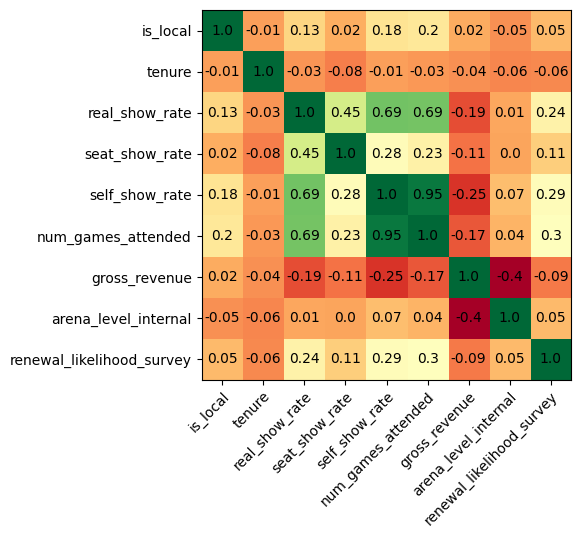

In [13]:
create_correlation_matrix(x_premier_train)

Interaction Variables: Attendance, Spen, Affinity, Engagement scores (comhbine highly coorelated variables or variables of similar field to create one variable)

Step 3: Training & Running Model

In [14]:
# create monte carlo simulation for model

def run_log_reg(ticket_type, x_train, x_test, y, acct_ids, num_simulations):

    ss = StandardScaler()
    x_train_scaler = ss.fit_transform(x_train)
    x_test_scaler = ss.fit_transform(x_test)

    if ticket_type == 'Full':
        weights = [1,1,2,2,1,1,1,1,2]
    else:
        weights = [1,1,1.5,1.5,1,1,1,1,2]
    x_train_scaler = x_train_scaler*weights
    x_test_scaler = x_test_scaler*weights

    predicted_probs = np.zeros((x_test_scaler.shape[0], num_simulations))

    for i in range(num_simulations):

        logi = LogisticRegression().fit(x_train_scaler, np.array(y))
        predicted_probs[:,i] = logi.predict_proba(x_test_scaler)[:,1]
    
    avg_predicted_probs = np.mean(predicted_probs, axis = 1)

    result_df = x_test
    result_df['avg_predicted_prob'] = avg_predicted_probs
    result_df = pd.concat([acct_ids, result_df], axis = 1)

    return result_df

In [15]:
# run Full model

full_final_df = run_log_reg('Full', x_full_train, x_full_test, y_full, full_acct_ids, 1000)

subtract = [random.uniform(.09, .11) for i in range(len(full_final_df))]

full_final_df['avg_predicted_prob'] = [value - subtract_value if value >= 0.12 else value for value, subtract_value in zip(full_final_df['avg_predicted_prob'], subtract)]

full_final_df['ticket_type'] = 'Full'

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was 

Step 4: Model Evaluation

In [16]:
logi = LogisticRegression().fit(x_premier_train, np.array(y_premier))

predicted = logi.predict(x_premier_train)

print(classification_report(predicted, y_premier))

              precision    recall  f1-score   support

           0       0.51      0.82      0.63       123
           1       0.99      0.96      0.98      2556

    accuracy                           0.96      2679
   macro avg       0.75      0.89      0.80      2679
weighted avg       0.97      0.96      0.96      2679



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

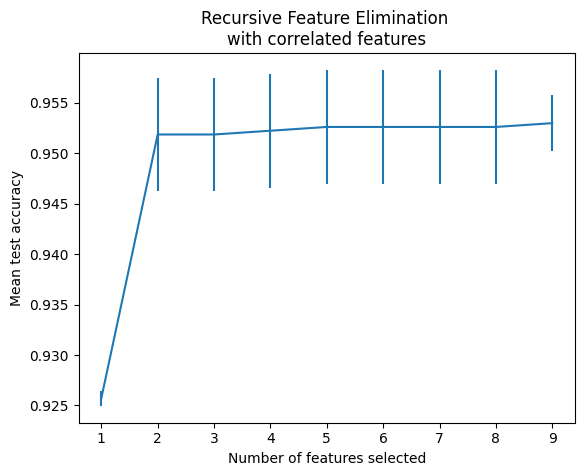

In [33]:
# Recersive Feature Elimination

selector = RFECV(estimator = LogisticRegression(), step = 1, min_features_to_select=1, scoring = 'accuracy')
selector.fit(x_premier_train, np.array(y_premier)).n_features_

cv_results = pd.DataFrame(selector.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

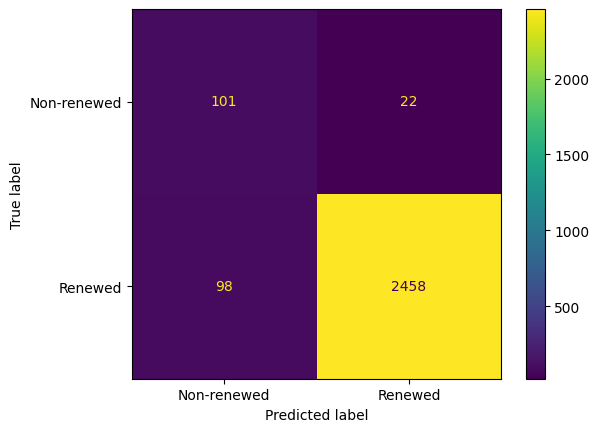

In [47]:
# AUC ROC

roc_auc_score(predicted, y_premier)

# Confusion Matrix

disp = ConfusionMatrixDisplay(confusion_matrix(predicted, y_premier), display_labels= ['Non-renewed', 'Renewed'])

disp.plot()

plt.show()

Step 5: Model Tuning